# Multilabel classification

In [1]:
%%capture
!pip install fastai fastcore

In [2]:
from fastai.vision.all import *


In [3]:
path = untar_data(URLs.PASCAL_2007)

In [4]:
path.ls()

(#8) [Path('/storage/data/pascal_2007/train'),Path('/storage/data/pascal_2007/test.json'),Path('/storage/data/pascal_2007/segmentation'),Path('/storage/data/pascal_2007/train.json'),Path('/storage/data/pascal_2007/valid.json'),Path('/storage/data/pascal_2007/test.csv'),Path('/storage/data/pascal_2007/train.csv'),Path('/storage/data/pascal_2007/test')]

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [6]:
df.nunique()

fname       5011
labels       473
is_valid       2
dtype: int64

## Create a DataBlock

In [7]:
def get_x(f): return path/'train'/f['fname']
def get_y(f): return f['labels'].split(" ")

In [8]:
# Split data into train and validation sets by is_valid 
def splitter(df):
    train_ids = df.index[df['is_valid']].tolist()
    valid_ids = df.index[~df['is_valid']].tolist()
    return train_ids, valid_ids

In [9]:
train_ids, valid_ids = splitter(df)
train_ids[:4], valid_ids[:4]

([0, 1, 2, 4], [3, 5, 9, 11])

In [12]:
dblock = DataBlock(blocks=(ImageBlock,MultiCategoryBlock),
                   splitter=splitter,
                   get_x = get_x, get_y = get_y,
                   item_tfms = RandomResizedCrop(128,min_scale=0.35))


In [13]:
dsets = dblock.datasets(df)

In [14]:
len(dsets.train), len(dsets.valid)


(2510, 2501)

In [15]:
dsets.train[0], dsets.valid[0]

((PILImage mode=RGB size=500x375,
  TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.])),
 (PILImage mode=RGB size=500x333,
  TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.])))

In [16]:
# Unique values in vocab
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [17]:
idx = torch.where(dsets.train[0][1]==1.)[0]
idx

TensorMultiCategory([8])

In [18]:
dsets.valid.vocab[idx]

(#1) ['chair']

In [19]:
# Load to DataLoader
dls = dblock.dataloaders(df)

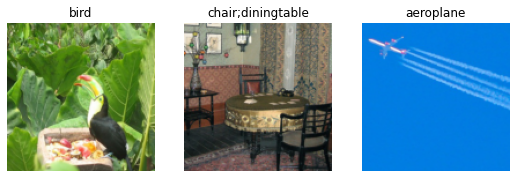

In [20]:
dls.show_batch(nrows=1, ncols=3)

## Build and train model

In [21]:
# Automatically chooses binary cross-entropy loss
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [22]:
# Freeze layers except last for 4 epochs, then train all for 3 epochs
learn.fine_tune(3, base_lr=3e-3,freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.953114,0.693602,0.233067,00:30
1,0.832234,0.557990,0.283187,00:23
2,0.615240,0.201300,0.824590,00:23
3,0.364739,0.128679,0.940804,00:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133058,0.116885,0.950240,00:28
1,0.114150,0.109495,0.952959,00:27
2,0.095703,0.104465,0.954358,00:28


## Find the best threshold for classification

In [26]:
predictions,targets = learn.get_preds()

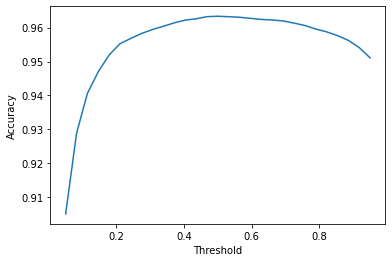

In [33]:
thresholds = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(predictions, targets, thresh=thresh, sigmoid=False) for thresh in thresholds]
plt.plot(thresholds,accs)
plt.ylabel('Accuracy')
plt.xlabel('Threshold');